In [2]:
import os
import re

In [2]:
!pip install pandas
!pip install matplotlib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# TASK 1

Defining the connection params for connecting to the Postgresql DB

In [4]:
HOST = "localhost"
DB = "tweetsDB"
USER = "postgres"
PASSWD = "passwd"

In [5]:
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, String, Integer, MetaData
from sqlalchemy.orm import declarative_base, sessionmaker

In [6]:
posgres_conn_str = f"postgresql://{USER}:{PASSWD}@{HOST}/{DB}"

In [7]:
engine = create_engine(posgres_conn_str)

# TASK 2

TODO:

    1. vytvorit si novy stlpec pre sentiment(neg, neu, pos, compound)
    2. joinut tweety s tweethashtagmi s hashtagmi 
    3. vyfiltrovat podla danych hashtagov, ktore chcem 
    4. vypocitat sentiment a zapisat do DB

Adding the sentiment columns to the tweets table

In [266]:
add_columns_query = """

    BEGIN TRAN 

    ALTER TABLE tweets
    ADD COLUMN neg numeric(6, 4),
    ADD COLUMN neu numeric(6, 4),
    ADD COLUMN pos numeric(6, 4),
    ADD COLUMN compound numeric(6, 4)

    COMMIT TRAN 

"""

In [8]:
try:
    engine.execute(add_columns_query)
    engine.commit()
except:
    print("Columns probably already exist")

Columns probably already exist


In [8]:
HASHTAG_FILTER = """'%%DeepstateVirus%%', '%%DeepStateVaccine%%','%%DeepStateFauci%%', '%%QAnon%%', '%%Agenda21%%', '%%CCPVirus%%', '%%ClimateChangeHoax%%',
'%%GlobalWarmingHoax%%', '%%ChinaLiedPeopleDied%%', '%%SorosVirus%%', '%%5GCoronavirus%%', '%%MAGA%%',
'%%WWG1WGA%%', '%%Chemtrails%%', '%%flatEarth%%', '%%MoonLandingHoax%%', '%%moonhoax%%', '%%illuminati%%',
'%%pizzaGateIsReal%%', '%%PedoGateIsReal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"""

In [9]:
# hashtag : conspiracy_theory
CONSPIRACY_THEORIES = {
 
        "deepstatevirus"                :   "Deep State",  
        "deepstatevaccine"              :   "Deep State",
        "deepstatefauci"                :   "Deep State",
        "qanon"                         :   "Qanon",
        "maga"                          :   "Qanon",
        "wwg1wga"                       :   "Qanon",
        "agenda21"                      :   "New world order",
        "ccpvirus"                      :   "The virus escaped from a Chinese lab", 
        "chinaliedpeopledied"           :   "The virus escaped from a Chinese lab",
        "climatechangehoax"             :   "GLobal Warming is HOAX",
        "globalwarminghoax"             :   "GLobal Warming is HOAX",
        "sorosvirus"                    :   "COVID19 and microchipping", 
        "billgates"                     :   "COVID19 and microchipping",
        "5gcoronavirus"                 :   "COVID19 is preaded by 5G",
        "moonlandinghoax"               :   "Moon landing is fake", 
        "moonhoax"                      :   "Moon landing is fake",
        "911truth"                      :   "9/11 was inside job",
        "911insidejob"                  :   "9/11 was inside job",
        "pizzagateisreal"               :   "Pizzagate conspiracy theory",
        "pedogateisreal"                :   "Pizzagate conspiracy theory",   
        "chemtrails"                    :   "Chemtrails",
        "flatearth"                     :   "FlatEarth",
        "illuminati"                    :   "Illuminati",
        "reptilians"                    :   "Reptilian conspiracy theory"
}

We need to match all the mutations of the hashtags:

In [11]:
filter_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array[{HASHTAG_FILTER.lower()}])
"""

In [12]:
filter_query

"\n    SELECT * \n    FROM hashtags\n    WHERE lower(value) LIKE ANY (array['%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'])\n"

In [13]:
qanon_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array['qanon'])
"""

In [15]:
df_qanon = pd.read_sql(qanon_query, engine)

In [17]:
df_filtered = pd.read_sql(filter_query, engine)

The filter matches 2018 hashtags

In [19]:
len(df_filtered)

2018

In [16]:
df_qanon

,id,value
0,15274024,QaNON
1,15168832,QANOn
2,15170088,qaNon
3,15189267,QAnoN
4,16070849,qaNON
5,15856421,qAnoN
6,15752301,QANon
7,18149870,qanoN
8,16204212,QaNon
9,16342002,QaNoN


We can see that hoaxer dont know grammar

Next we define our emoji and regex pattern filter to filter the content of the tweet from hashtags, mentions and other metacharacters.

In [21]:
emoji_pat = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        # u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        # u"\U00002702-\U000027B0"
        # u"\U000024C2-\U0001F251"  # mandarinian chars
        u"\U00010000-\U0010ffff"
        u"\U0001f926-\U0001f937"
        u"\u2600-\u2B55"
        u"\u2640-\u2642" 
        u"\u200d"
        u"\u231a"
        u"\u23e9"
        u"\u23cf"
        u"\ufe0f"  # dingbats
        u"\u3030"
                        "]+", flags = re.UNICODE)



# returns the parsed line using the regex that strips away the # and @
def parse_line(line):
    res = re.sub("[#@]+[\w.-]*", "", line)
    res = emoji_pat.sub(r'',res)
    return res.lstrip().rstrip()

In [64]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def compute_sentiment_and_write(line):
    # parse the line and compute the sentiment
    id = line['id']
    sentiment = sid.polarity_scores(parse_line(line['content']))
    # print(parse_line(line['content']))
    # print(sid.polarity_scores(parse_line(line['content'])))
    try:
        engine.execute(f"""
            BEGIN TRAN 

            UPDATE tweets
            SET neg = {sentiment['neg']},
                neu = {sentiment['neu']},
                pos = {sentiment['pos']},
                compound = {sentiment['compound']}
            WHERE id = '{id}';

            COMMIT TRAN 
        """)
        
    except:
        print("Something went wrong during write")


# TODO upravit funkciu aby sa transakcia nevolala pri kazdom inserte

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kdeni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
import nltk
import numpy as np
!pip install tqdm
from tqdm import tqdm
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# 2152424 / 21524 ~= 100
chunk_offset = 100

def compute_sentiment_and_write2(dataframe):
    # parse the lines and compute the sentiment

    with engine.connect() as connection:
        for chunk in tqdm(np.array_split(dataframe, chunk_offset)):
            # begin the transaction
            with connection.begin():
                for index, line in chunk.iterrows():
                    id = line['tweetid']
                    sentiment = sid.polarity_scores(parse_line(line['content']))                
                    try:
                        connection.execute(f"""
                        UPDATE tweets
                            SET neg = {sentiment['neg']},
                                neu = {sentiment['neu']},
                                pos = {sentiment['pos']},
                                compound = {sentiment['compound']}
                            WHERE id = '{id}';""")
                        
                    except:
                        print("Something went wrong during write")



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kdeni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
lower_hastag_filter = HASHTAG_FILTER.lower()

In [12]:
lower_hastag_filter

"'%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"

In [39]:
query = f"""
                SELECT tweets.id as tweetID, tweets.content, h.id as hashtagID, h.value as hashtagVal
                FROM tweets
                JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
                JOIN hashtags as h ON h.id = th.hashtag_id
                WHERE lower(h.value) ILIKE ANY (array[{lower_hastag_filter}])
        
"""

Get all the tweets that match the hashtag filter

In [40]:
df_filtered_tweets = pd.read_sql(query, engine)

In [52]:
len(df_filtered_tweets)

3656142

We can see the parsing method in action.

In [41]:
df_filtered_tweets['content'][20]

"RT @Jordan_Sather_: I didn't say a word about #QAnon in my tweets re: the coronavirus and vaccines, but nevertheless fake news Buzzfeed use…"

In [42]:
parse_line(df_filtered_tweets['content'][20])

"RT : I didn't say a word about  in my tweets re: the coronavirus and vaccines, but nevertheless fake news Buzzfeed use…"

In [43]:
df_filtered_tweets['hashtagval'] = df_filtered_tweets['hashtagval'].apply(lambda x: x.lower()) 

Remove duplicates

In [70]:
df_unique_filtered_tweets = df_filtered_tweets.drop_duplicates(subset=['tweetid'])

In [71]:
df_filtered_tweets.head(15)

,tweetid,content,hashtagid,hashtagval
0,1220789297474916355,@being_nontheist @SenatorDurbin @Lawrence @Sen...,18287,wwg1wga_worldwide
1,1220786014006009856,Update: #Coronavirus Is Spreading In The US No...,14415,maga
2,1220491726214717440,I didn't say a word about #QAnon in my tweets ...,20506,qanon
3,1220797748502417409,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
4,1220728654327664640,Next Deathly Plague?\n\nA coronavirus outbreak...,14415,maga
5,1220792996582645760,Insightful essay on the Chinese Coronavirus.\n...,24818,maga
6,1220795094326005760,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
7,1220498546492956672,"@Jordan_Sather_ Halo!, please find the unroll ...",20506,qanon
8,1220796328265101312,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
9,1220796147759026176,🛑 Gateway Pundit News 🛑 \n\n👉 Senator Tom Cott...,14415,maga


In [72]:
df_unique_filtered_tweets.head(15)

,tweetid,content,hashtagid,hashtagval
0,1220789297474916355,@being_nontheist @SenatorDurbin @Lawrence @Sen...,18287,wwg1wga_worldwide
1,1220786014006009856,Update: #Coronavirus Is Spreading In The US No...,14415,maga
2,1220491726214717440,I didn't say a word about #QAnon in my tweets ...,20506,qanon
3,1220797748502417409,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
4,1220728654327664640,Next Deathly Plague?\n\nA coronavirus outbreak...,14415,maga
5,1220792996582645760,Insightful essay on the Chinese Coronavirus.\n...,24818,maga
6,1220795094326005760,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
7,1220498546492956672,"@Jordan_Sather_ Halo!, please find the unroll ...",20506,qanon
8,1220796328265101312,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
9,1220796147759026176,🛑 Gateway Pundit News 🛑 \n\n👉 Senator Tom Cott...,14415,maga


In [73]:
len(df_unique_filtered_tweets)

2152424

Computing the sentiment and writing it to the db

In [88]:
compute_sentiment_and_write2(df_unique_filtered_tweets)

100%|██████████| 100/100 [27:01<00:00, 16.22s/it]


In [316]:
# df_unique_filtered_tweets.apply(lambda x: compute_sentiment_and_write(x), axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
3656131    None
3656133    None
3656134    None
3656135    None
3656140    None
Length: 2152424, dtype: object

# TASK 3

Creating the consp_theory tables as well the link between hashtags and consptheory

In [150]:
consp_theory_link = df_filtered_tweets.loc[ : , ["hashtagid", "hashtagval", "tweetid"]]

In [151]:
len(consp_theory_link)

3656142

In [152]:
consp_theory_link.head(10)

,hashtagid,hashtagval,tweetid
0,18287,wwg1wga_worldwide,1220789297474916355
1,14415,maga,1220786014006009856
2,20506,qanon,1220491726214717440
3,20506,qanon,1220797748502417409
4,14415,maga,1220728654327664640
5,24818,maga,1220792996582645760
6,20506,qanon,1220795094326005760
7,20506,qanon,1220498546492956672
8,20506,qanon,1220796328265101312
9,14415,maga,1220796147759026176


In [153]:
consp_theory_link[consp_theory_link['tweetid'] == str(1256801279139069952)]

,hashtagid,hashtagval,tweetid
18412,20506,qanon,1256801279139069952
18416,15171991,chemtrails,1256801279139069952
18421,25089,wwg1wga,1256801279139069952
18423,259500,wwg1wgaworldwide,1256801279139069952


In [154]:
consp_theory_link = consp_theory_link.drop_duplicates(subset=['hashtagid'])

In [155]:
len(consp_theory_link)

2018

In [156]:
consp_theory_link = consp_theory_link.reset_index(drop=True)

In [157]:
consp_theory_link.head(10)

,hashtagid,hashtagval,tweetid
0,18287,wwg1wga_worldwide,1220789297474916355
1,14415,maga,1220786014006009856
2,20506,qanon,1220491726214717440
3,24818,maga,1220792996582645760
4,25089,wwg1wga,1219860725440503809
5,25091,qanon,1219860725440503809
6,27195,qanon,1220790900324020224
7,33792,chemtrails,1220415227394695170
8,29024,qanons,1220577746696462342
9,61453,keralalifemagazine,1220193480296689664


Get the name of the consp. theory.

In [13]:
CONSPIRACY_THEORIES_LIST = list(CONSPIRACY_THEORIES.keys())
THEORY_LIST = list(set(CONSPIRACY_THEORIES.values()))

def chceck_theory(hashtag):
    for key in CONSPIRACY_THEORIES_LIST:
        if key in hashtag:
            return CONSPIRACY_THEORIES.get(key)


Mapping the hashtag to the theory name.

In [159]:
consp_theory_link['theory'] = consp_theory_link.apply(lambda x: chceck_theory(x['hashtagval']), axis=1)

In [160]:
consp_theory_link.head(10)

,hashtagid,hashtagval,tweetid,theory
0,18287,wwg1wga_worldwide,1220789297474916355,Qanon
1,14415,maga,1220786014006009856,Qanon
2,20506,qanon,1220491726214717440,Qanon
3,24818,maga,1220792996582645760,Qanon
4,25089,wwg1wga,1219860725440503809,Qanon
5,25091,qanon,1219860725440503809,Qanon
6,27195,qanon,1220790900324020224,Qanon
7,33792,chemtrails,1220415227394695170,Chemtrails
8,29024,qanons,1220577746696462342,Qanon
9,61453,keralalifemagazine,1220193480296689664,Qanon


Creating the conspiracy theory table

In [14]:
CONSP_VALUES = list(set(CONSPIRACY_THEORIES.values()))

In [162]:
id_arr = [x for x in range(1, len(CONSP_VALUES) + 1)]

In [163]:
consp_theory_tab = pd.DataFrame(list(zip(id_arr, CONSP_VALUES)), columns=["id", "theory_name"])

In [164]:
consp_theory_tab

,id,theory_name
0,1,COVID19 is preaded by 5G
1,2,GLobal Warming is HOAX
2,3,Moon landing is fake
3,4,Pizzagate conspiracy theory
4,5,Qanon
5,6,The virus escaped from a Chinese lab
6,7,New world order
7,8,Deep State
8,9,9/11 was inside job
9,10,FlatEarth


Schema for the table

In [165]:
try:
    engine.execute("""
        BEGIN;

        CREATE TABLE IF NOT EXISTS consp_theories (
        id INT GENERATED ALWAYS AS IDENTITY,
        theory_name varchar(255),
        PRIMARY KEY(id)
    );   

        COMMIT;
    """)
except:
    print("Something went wrong")

Inserting the consp_theories

In [128]:
try:
    with engine.connect() as connection:
        with connection.begin():
            for _, row in consp_theory_tab.iterrows():
                engine.execute(f"""
                    
                    INSERT INTO consp_theories(theory_name)
                    VALUES ('{row['theory_name']}');
                    
                """)
except:
    print("Somthing went wrong")

In [166]:
df_theories = pd.read_sql(
    """
    SELECT id, theory_name
    FROM 
    consp_theories
    """
    , engine)

In [168]:
df_theories

,id,theory_name
0,1,COVID19 is preaded by 5G
1,2,GLobal Warming is HOAX
2,3,Moon landing is fake
3,4,Pizzagate conspiracy theory
4,5,Qanon
5,6,The virus escaped from a Chinese lab
6,7,New world order
7,8,Deep State
8,9,9/11 was inside job
9,10,FlatEarth


Creating a dictionary to map the conspiracy theories to the hashtags via the conspiracy theory id

In [169]:
mapping_dict = dict(zip(df_theories['theory_name'], df_theories['id']))

In [170]:
mapping_dict

{'COVID19 is preaded by 5G': 1,
 'GLobal Warming is HOAX': 2,
 'Moon landing is fake': 3,
 'Pizzagate conspiracy theory': 4,
 'Qanon': 5,
 'The virus escaped from a Chinese lab': 6,
 'New world order': 7,
 'Deep State': 8,
 '9/11 was inside job': 9,
 'FlatEarth': 10,
 'Illuminati': 11,
 'Reptilian conspiracy theory': 12,
 'COVID19 and microchipping': 13,
 'Chemtrails': 14}

Creating a new column and adding the mapping

In [171]:
consp_theory_link['theory_id'] = consp_theory_link.apply(lambda x: mapping_dict.get(x['theory']), axis=1)

In [172]:
consp_theory_link

,hashtagid,hashtagval,tweetid,theory,theory_id
0,18287,wwg1wga_worldwide,1220789297474916355,Qanon,5
1,14415,maga,1220786014006009856,Qanon,5
2,20506,qanon,1220491726214717440,Qanon,5
3,24818,maga,1220792996582645760,Qanon,5
4,25089,wwg1wga,1219860725440503809,Qanon,5
...,...,...,...,...,...
2013,37283281,magamisinformation,1244668722163351556,Qanon,5
2014,37295422,inkedmagazine,1248276196112175104,Qanon,5
2015,37375431,blomaga,1253872845890842624,Qanon,5
2016,37408594,magadumb,1258858634899009538,Qanon,5


In [173]:
hash_consp_mapping = consp_theory_link.loc[:, ['hashtagid', 'theory_id']]

In [174]:
hash_consp_mapping = hash_consp_mapping.drop_duplicates(subset=['hashtagid'])

In [175]:
hash_consp_mapping.dtypes

hashtagid    int64
theory_id    int64
dtype: object

In [177]:
hash_consp_mapping.head(15)

,hashtagid,theory_id
0,18287,5
1,14415,5
2,20506,5
3,24818,5
4,25089,5
5,25091,5
6,27195,5
7,33792,14
8,29024,5
9,61453,5


In [178]:
hash_consp_mapping['hashtagid'] = hash_consp_mapping['hashtagid'].astype(int)
hash_consp_mapping = hash_consp_mapping.dropna()
hash_consp_mapping['theory_id'] = hash_consp_mapping['theory_id'].astype(int)

In [180]:
hash_consp_mapping.head(15)

,hashtagid,theory_id
0,18287,5
1,14415,5
2,20506,5
3,24818,5
4,25089,5
5,25091,5
6,27195,5
7,33792,14
8,29024,5
9,61453,5


Adding the mapping table between theories and hashtags

In [181]:
try:
    engine.execute("""
        BEGIN;

        CREATE TABLE IF NOT EXISTS hash_consptheories_link (
        id int GENERATED ALWAYS AS IDENTITY,
        hashtag_id int,
        consp_theory_id int,
        PRIMARY KEY(id),
        CONSTRAINT fk_hashtag
            FOREIGN KEY(hashtag_id)
                REFERENCES hashtags(id)
                ON DELETE SET NULL,

        CONSTRAINT fk_consptheory        
            FOREIGN KEY(consp_theory_id)
                REFERENCES consp_theories(id)
                ON DELETE SET NULL
    );  

    COMMIT; 
    """)
    
except:
    print("Something went wrong")

In [182]:
try:
    with engine.connect() as connection:
        with connection.begin():
            for _, row in hash_consp_mapping.iterrows():
                # print(row['theory_name'])
                engine.execute(f"""
                    
                    INSERT INTO hash_consptheories_link(hashtag_id, consp_theory_id)
                    VALUES ('{int(row['hashtagid'])}', '{int(row['theory_id'])}');
                   
                """)
except:
    print("Somthing went wrong")

# TASK 4

The subselect gets us the tweets with extreme sentiment and groups them by the conspiracy theory name, the extracted week in which the tweet was created and also by the compound and the neutral sentiment of the tweet. The outer select computes mainly the agregate absolute sum of the compound and neutral sentiment values of the tweets, then groups them by the week in which they were created and the theory it belongs to. At last the result is ordered by the theory. 

In [25]:
sentiment_query = """
    SELECT res.theory, res.week, count(res.compound) as tweet_count, sum(abs(res.compound))/count(res.compound) as tweet_extreme_count, sum(abs(res.neu))/count(res.compound) as tweet_neutral_count
    FROM 
    (
        SELECT tweets.compound, tweets.neu, EXTRACT(WEEK from tweets.happened_at) as week, ct.theory_name as theory
            FROM tweets
            JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
            JOIN hashtags as h ON h.id = th.hashtag_id
            JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
            JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
            WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
            group by (ct.theory_name, week, tweets.compound, tweets.neu)
        ) as res
        
    GROUP BY (res.week, res.theory)
    ORDER BY res.theory
"""

In [26]:
try:
    df_week_extreme_comp = pd.read_sql(sentiment_query, engine)
except:
    print("Something went wrong")

In [27]:
df_week_extreme_comp.head(15)

,theory,week,tweet_count,tweet_extreme_count,tweet_neutral_count
0,9/11 was inside job,5.0,1,0.557400,0.662000
1,9/11 was inside job,8.0,1,0.648600,0.654000
2,9/11 was inside job,15.0,3,0.643500,0.801667
3,9/11 was inside job,16.0,2,0.575650,0.762000
4,9/11 was inside job,18.0,4,0.725300,0.709250
5,9/11 was inside job,19.0,2,0.736600,0.740500
6,9/11 was inside job,22.0,2,0.590450,0.870500
7,COVID19 and microchipping,8.0,2,0.655650,0.819500
8,COVID19 is preaded by 5G,13.0,1,0.790600,0.759000
9,COVID19 is preaded by 5G,14.0,20,0.743145,0.662450


In [28]:
df_week_extreme_comp['week'] = df_week_extreme_comp['week'].astype(int)


    #######
    ---  Deep State ---
    ######
            theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
15  Deep State    14            7             0.624857             0.792429
16  Deep State    15           15             0.715573             0.716400
17  Deep State    16            3             0.650667             0.569333
18  Deep State    17            2             0.693300             0.680000
19  Deep State    18            5             0.778560             0.725400
20  Deep State    20            3             0.634733             0.816667
21  Deep State    22            1             0.700300             0.616000


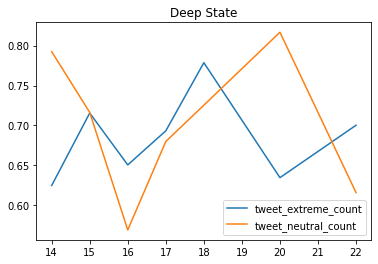


    #######
    ---  9/11 was inside job ---
    ######
                    theory  week  tweet_count  tweet_extreme_count  \
0  9/11 was inside job     5            1              0.55740   
1  9/11 was inside job     8            1              0.64860   
2  9/11 was inside job    15            3              0.64350   
3  9/11 was inside job    16            2              0.57565   
4  9/11 was inside job    18            4              0.72530   
5  9/11 was inside job    19            2              0.73660   
6  9/11 was inside job    22            2              0.59045   

   tweet_neutral_count  
0             0.662000  
1             0.654000  
2             0.801667  
3             0.762000  
4             0.709250  
5             0.740500  
6             0.870500  


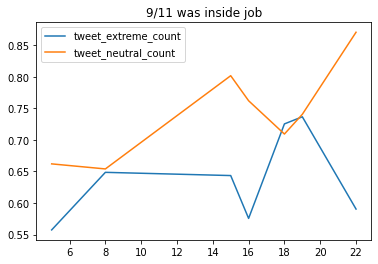


    #######
    ---  GLobal Warming is HOAX ---
    ######
                        theory  week  tweet_count  tweet_extreme_count  \
35  GLobal Warming is HOAX     5            7             0.766743   
36  GLobal Warming is HOAX     6            5             0.680960   
37  GLobal Warming is HOAX     8            1             0.850400   
38  GLobal Warming is HOAX     9            1             0.750600   
39  GLobal Warming is HOAX    20            2             0.608550   

    tweet_neutral_count  
35               0.6990  
36               0.5690  
37               0.7760  
38               0.8410  
39               0.8605  


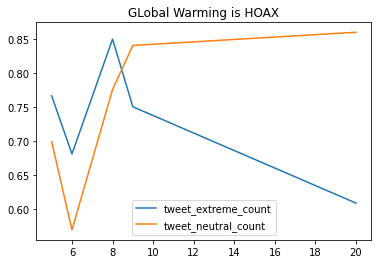


    #######
    ---  Chemtrails ---
    ######
            theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
40  Chemtrails     4            6             0.723550             0.693333
41  Chemtrails     5            7             0.703371             0.706857
42  Chemtrails     6            2             0.735450             0.675500
43  Chemtrails    14            6             0.700983             0.680667
44  Chemtrails    15           13             0.667031             0.777385
45  Chemtrails    16           19             0.680705             0.737789
46  Chemtrails    17            9             0.712544             0.633778
47  Chemtrails    18            9             0.723311             0.715111
48  Chemtrails    19            9             0.758811             0.756111
49  Chemtrails    20           10             0.649890             0.662800
50  Chemtrails    21            3             0.678667             0.773000
51  Chemtrails    22            6   

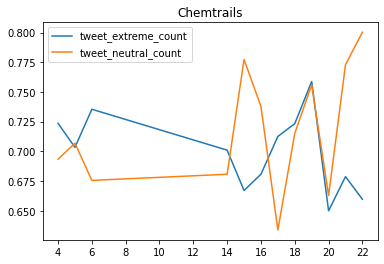


    #######
    ---  Reptilian conspiracy theory ---
    ######
                              theory  week  tweet_count  tweet_extreme_count  \
134  Reptilian conspiracy theory    15            1             0.541100   
135  Reptilian conspiracy theory    16            4             0.645675   
136  Reptilian conspiracy theory    17            3             0.620833   
137  Reptilian conspiracy theory    18            3             0.592567   

     tweet_neutral_count  
134             0.889000  
135             0.594250  
136             0.683333  
137             0.766667  


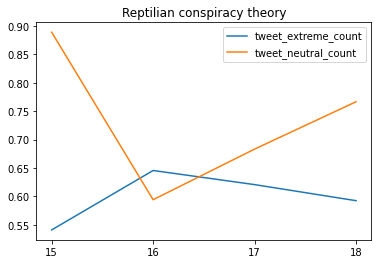


    #######
    ---  Moon landing is fake ---
    ######
                      theory  week  tweet_count  tweet_extreme_count  \
66  Moon landing is fake    16            1             0.526700   
67  Moon landing is fake    19            1             0.526700   
68  Moon landing is fake    20            3             0.562133   
69  Moon landing is fake    21            1             0.633000   
70  Moon landing is fake    22            1             0.633000   

    tweet_neutral_count  
66                0.793  
67                0.793  
68                0.778  
69                0.736  
70                0.736  


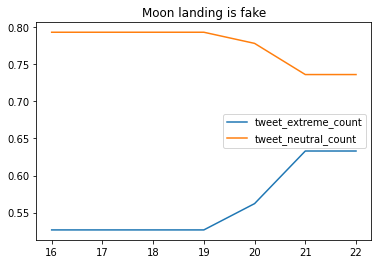


    #######
    ---  Qanon ---
    ######
        theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
99   Qanon     1            2             0.825250             0.668500
100  Qanon     2            2             0.706650             0.830500
101  Qanon     3            7             0.747843             0.763714
102  Qanon     4          171             0.702671             0.715754
103  Qanon     5          623             0.698203             0.706204
104  Qanon     6          186             0.701935             0.699167
105  Qanon     7          195             0.694905             0.705036
106  Qanon     8          142             0.682946             0.717965
107  Qanon     9          531             0.719368             0.701041
108  Qanon    11            4             0.725550             0.705000
109  Qanon    12            7             0.738600             0.721000
110  Qanon    13           14             0.677614             0.773929
111  Qanon    14 

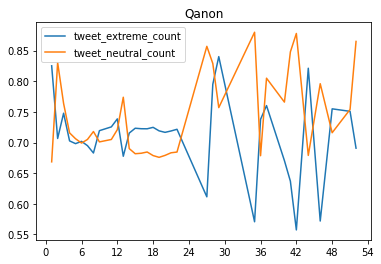


    #######
    ---  The virus escaped from a Chinese lab ---
    ######
                                       theory  week  tweet_count  \
138  The virus escaped from a Chinese lab     5            2   
139  The virus escaped from a Chinese lab     6            3   
140  The virus escaped from a Chinese lab     7            2   
141  The virus escaped from a Chinese lab    12            5   
142  The virus escaped from a Chinese lab    13           16   
143  The virus escaped from a Chinese lab    14          315   
144  The virus escaped from a Chinese lab    15          346   
145  The virus escaped from a Chinese lab    16          365   
146  The virus escaped from a Chinese lab    17          265   
147  The virus escaped from a Chinese lab    18          194   
148  The virus escaped from a Chinese lab    19          122   
149  The virus escaped from a Chinese lab    20           62   
150  The virus escaped from a Chinese lab    21            3   
151  The virus escaped fro

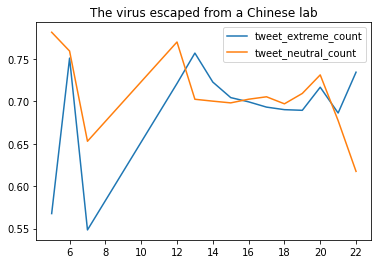


    #######
    ---  Illuminati ---
    ######
            theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
52  Illuminati     4            3             0.640700             0.824667
53  Illuminati     5            5             0.677480             0.767600
54  Illuminati     6            2             0.712100             0.755500
55  Illuminati     7            1             0.778300             0.562000
56  Illuminati     9            1             0.598300             0.770000
57  Illuminati    14           17             0.670700             0.716294
58  Illuminati    15           24             0.643321             0.734917
59  Illuminati    16           61             0.688748             0.655164
60  Illuminati    17           32             0.686441             0.707781
61  Illuminati    18           31             0.659400             0.694806
62  Illuminati    19           18             0.687889             0.701833
63  Illuminati    20           30   

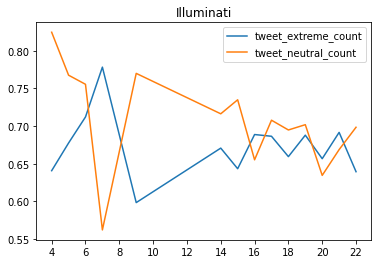


    #######
    ---  New world order ---
    ######
                 theory  week  tweet_count  tweet_extreme_count  \
71  New world order     4           49             0.734333   
72  New world order     5          109             0.767888   
73  New world order     6           14             0.711971   
74  New world order     7           11             0.661218   
75  New world order     8            3             0.774733   
76  New world order     9            3             0.667533   
77  New world order    13            1             0.983700   
78  New world order    14           12             0.751092   
79  New world order    15           12             0.706133   
80  New world order    16           13             0.664862   
81  New world order    17            6             0.702183   
82  New world order    18           25             0.668428   
83  New world order    19           11             0.644164   
84  New world order    20           12             0.695933  

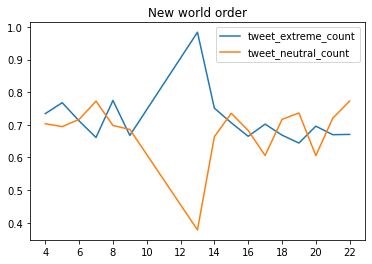


    #######
    ---  COVID19 is preaded by 5G ---
    ######
                          theory  week  tweet_count  tweet_extreme_count  \
8   COVID19 is preaded by 5G    13            1             0.790600   
9   COVID19 is preaded by 5G    14           20             0.743145   
10  COVID19 is preaded by 5G    15           15             0.641093   
11  COVID19 is preaded by 5G    16           10             0.690020   
12  COVID19 is preaded by 5G    17           18             0.695233   
13  COVID19 is preaded by 5G    18            5             0.638900   
14  COVID19 is preaded by 5G    19            5             0.711500   

    tweet_neutral_count  
8              0.759000  
9              0.662450  
10             0.756600  
11             0.744000  
12             0.703333  
13             0.661600  
14             0.692600  


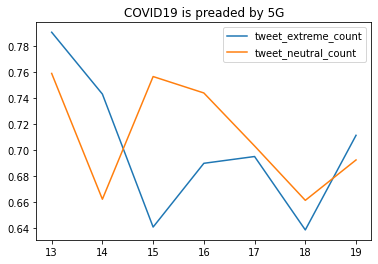


    #######
    ---  Pizzagate conspiracy theory ---
    ######
                             theory  week  tweet_count  tweet_extreme_count  \
87  Pizzagate conspiracy theory     6            1             0.745600   
88  Pizzagate conspiracy theory    13            1             0.599400   
89  Pizzagate conspiracy theory    14           16             0.684362   
90  Pizzagate conspiracy theory    15           40             0.698183   
91  Pizzagate conspiracy theory    16           56             0.668907   
92  Pizzagate conspiracy theory    17           22             0.678441   
93  Pizzagate conspiracy theory    18           59             0.695810   
94  Pizzagate conspiracy theory    19           17             0.680435   
95  Pizzagate conspiracy theory    20           36             0.717069   
96  Pizzagate conspiracy theory    21           27             0.696148   
97  Pizzagate conspiracy theory    22           30             0.693010   
98  Pizzagate conspiracy theory

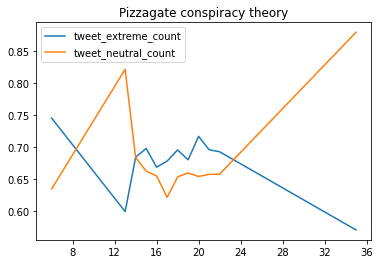


    #######
    ---  COVID19 and microchipping ---
    ######
                          theory  week  tweet_count  tweet_extreme_count  \
7  COVID19 and microchipping     8            2              0.65565   

   tweet_neutral_count  
7               0.8195  


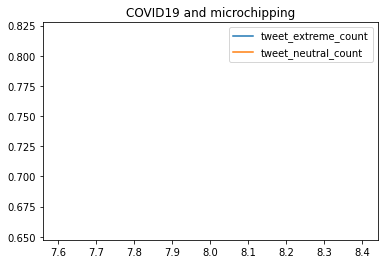


    #######
    ---  FlatEarth ---
    ######
           theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
22  FlatEarth     5            4             0.688125             0.733250
23  FlatEarth     6            1             0.542300             0.791000
24  FlatEarth     7            2             0.578900             0.812000
25  FlatEarth     9            1             0.636900             0.538000
26  FlatEarth    14            3             0.678067             0.717000
27  FlatEarth    15            4             0.627075             0.731750
28  FlatEarth    16            6             0.626817             0.651833
29  FlatEarth    17            5             0.647600             0.731200
30  FlatEarth    18            9             0.714178             0.606000
31  FlatEarth    19            5             0.706300             0.751200
32  FlatEarth    20            4             0.699325             0.704250
33  FlatEarth    21           13             0.74

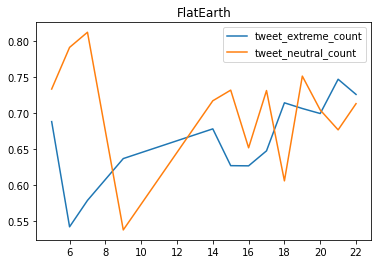

In [29]:
from matplotlib.ticker import MaxNLocator

for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name}  ---
    ######
    {df_week_extreme_comp[df_week_extreme_comp['theory'] == name]}""")


    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


    ax.set_title(name)
  
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['week'], 
        df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_extreme_count'], label="tweet_extreme_count")
    
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['week'], 
        df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_neutral_count'], label="tweet_neutral_count")
    
    plt.legend()
    
    # show plot
    plt.show()
        
    

# TASK 5

In [92]:
accounts_query = """
    SELECT ct.theory_name, acc.id , acc.name, acc.screen_name, count(tweets.id) as tweet_count
    FROM tweets
    JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
    JOIN hashtags as h ON h.id = th.hashtag_id
    JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
    JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
    JOIN tweet_mentions as tm ON tm.tweet_id = tweets.id
    JOIN accounts as acc ON tm.account_id = acc.id
    WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
    group by (ct.theory_name, acc.id, acc.name, acc.screen_name)
    ORDER BY ct.theory_name ASC
"""

In [93]:
try:
    df_top_accounts_for_consp = pd.read_sql(accounts_query, engine)
except:
    print("Something went wrong")

In [94]:
df_top_accounts_for_consp.head(15)

,theory_name,id,name,screen_name,tweet_count
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1
3,9/11 was inside job,1173334893104967682,Anonymous Busch,AnonymousBusch,1
4,COVID19 and microchipping,23125257,George Soros,georgesoros,1
...,...,...,...,...,...
3870,The virus escaped from a Chinese lab,1381803231739846658,Vincent Wong,initialvw,1
3871,The virus escaped from a Chinese lab,1405060253159497730,The Core,SocialM85897394,1
3872,The virus escaped from a Chinese lab,1405799406113157128,Wesley Fangnats,WesFangNats,1
3873,The virus escaped from a Chinese lab,1407004701682454529,Leaih,leaih,1


In [96]:
df_top_accounts_for_consp = df_top_accounts_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])

In [97]:
df_top_accounts_for_consp.head(15)

,theory_name,id,name,screen_name,tweet_count
3608,The virus escaped from a Chinese lab,2313027666,Jennifer Zeng 曾錚,jenniferatntd,113
3572,The virus escaped from a Chinese lab,1339488762,Solomon Yue,SolomonYue,96
3128,The virus escaped from a Chinese lab,14499829,World Health Organization (WHO),WHO,95
3224,The virus escaped from a Chinese lab,25073877,Donald J. Trump,realDonaldTrump,65
3833,The virus escaped from a Chinese lab,1232414456589750272,China in Focus - NTD,ChinaInFocusNTD,61
...,...,...,...,...,...
5,COVID19 and microchipping,188363529,"Alexander Soros, PhD",AlexanderSoros,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1


In [98]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name}  ---
    ######
    {df_top_accounts_for_consp[df_top_accounts_for_consp['theory_name'] == name].loc[ :, ['id', 'name', 'screen_name', 'tweet_count']].head(10)}""")


    #######
    ---  9/11 was inside job ---
    ######
                        id                             name     screen_name  \
1             55905770                Miriam Selmi Reed       mimiselmi   
0             14499829  World Health Organization (WHO)             WHO   
2           2213750137                Madeleine Stäubli  MadeleineRodun   
3  1173334893104967682                  Anonymous Busch  AnonymousBusch   

   tweet_count  
1            2  
0            1  
2            1  
3            1  

    #######
    ---  FlatEarth ---
    ######
                        id                 name      screen_name  tweet_count
48  929387229880946688         Jack William    Jackszooquest            4
37            25073877      Donald J. Trump  realDonaldTrump            2
35            10228272              YouTube          YouTube            1
36            17471979  National Geographic           NatGeo            1
38            38190348               Daniel  crimesceneve

# TASK 6

In [52]:
hash_tags_query = """
SELECT ct.theory_name, res.value as hashtag_val, sum(res.tweet_count) as tweet_count
FROM
	(SELECT h.id, h.value, count(distinct(tweets.id)) as tweet_count
	FROM tweets
	JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
	JOIN hashtags as h ON h.id = th.hashtag_id
	JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
	JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
	WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
	group by (h.id)
	ORDER BY h.value ASC) as res

JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = res.id
JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
GROUP BY (ct.theory_name, res.id, res.value)
ORDER BY ct.theory_name ASC
"""

In [53]:
try:
    df_top_hashtags_for_consp = pd.read_sql(hash_tags_query, engine)
except:
    print("Something went wrong")

In [54]:
df_top_hashtags_for_consp = df_top_hashtags_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])
df_top_hashtags_for_consp['tweet_count'] = df_top_hashtags_for_consp['tweet_count'].astype(int)

In [55]:
df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == "The virus escaped from a Chinese lab"].head(10)

,theory_name,hashtag_val,tweet_count
883,The virus escaped from a Chinese lab,CCPVirus,1303
884,The virus escaped from a Chinese lab,ChinaLiedPeopleDied,954
881,The virus escaped from a Chinese lab,CCPvirus,151
885,The virus escaped from a Chinese lab,ccpvirus,26
889,The virus escaped from a Chinese lab,CCPVirus_Coronavirus,24
886,The virus escaped from a Chinese lab,chinaliedpeopledied,9
888,The virus escaped from a Chinese lab,CCPVIRUS,7
882,The virus escaped from a Chinese lab,ccpVirus,3
887,The virus escaped from a Chinese lab,CCPVirusHoax,3
894,The virus escaped from a Chinese lab,CCPVirusIsReal,2


In [58]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == name].loc[ :, ['hashtag_val', 'tweet_count']].head(10)}""")


    #######
    ---  9/11 was inside job ---
    ######
           hashtag_val  tweet_count
0         911Truth           24
1         911truth            8
2         911Truth            2
3     911insidejob            2
4  911insidejobber            1

    #######
    ---  FlatEarth ---
    ######
              hashtag_val  tweet_count
15          FlatEarth           47
14          flatearth           23
18  researchflatearth           11
16          FLATEARTH            6
21        FlatEarther            3
23   flatearthsociety            3
25   FlatEarthSociety            3
17  ResearchFlatEarth            2
24       flatearthers            2
13       FlatEarthers            1

    #######
    ---  Qanon ---
    ######
             hashtag_val  tweet_count
74             QAnon       415088
76           WWG1WGA       200215
82             Qanon       128874
72              MAGA        70332
77             qanon        65261
78             QANON        56806
92  WWG1WGAWORLDWIDE      